# Itemset Mining

**Group 19**

*Cátia Antunes* (fc60494) - -h  
*Donato Aveiro* (fc46269) - -h  
*Márcia Vital* (fc59488) - -h  
*Seán Gorman* (fc59492) - -h 

**1. Analysis of itemset mining algorithms and their efficiency**

Objective 1 - Analyze the itemset/rules generation procedure

    From the approaches used in classes make a performance analysis up to a threshold level of support
    Discuss your findings and identify a good candidate method
    Define a good support threshold for analysis according to your computational capabilities


In [2]:
# Modules required
import pandas as pd
import numpy as np
import pickle
from mlxtend.preprocessing import TransactionEncoder
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules
from pyECLAT import ECLAT
import time
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from pyfim import pyeclat


1.1. Data Loading and Preparation

In [3]:
#Read product names and IDs from products.txt in utf-8 format
products = pd.read_csv('products.txt', sep='\t', encoding='utf-8')
products[:5]


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [4]:
# create a dictionary of the products
product_dict = dict(zip(products['product_id'], products['product_name']))

In [5]:
# Open the pickle file and load the order data from pickle file
with open('order_products.pickle', 'rb') as file:
    # Load the order data from the pickle file
    order_products = pickle.load(file) 

In [6]:
# list of list of products in each order
order_products_list = [list(order) for order in order_products.values()]
order_products_list[:2]

[[33120, 28985, 9327, 45918, 30035, 17794, 40141, 1819, 43668],
 [33754, 24838, 17704, 21903, 17668, 46667, 17461, 32665]]

In [31]:
# Count the number of transactions in order_products_list
print('Number of transactions: ', len(order_products_list))

Number of transactions:  3214874


In [32]:
# Count the number of items in order_products_list
print('Number of items: ', len(set([item for order in order_products_list for item in order])))

Number of items:  49677


In [7]:
# transform the order_product_lists into a binary matrix
te = TransactionEncoder()
sparse_matrix = te.fit_transform(order_products_list, sparse=True) 
#17 seconds

In [8]:
# Creating a dataframe from the binary sparse matrix
orders_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, columns=te.columns_)
orders_df[:2]

,1,2,3,4,5,6,7,8,9,10,...,49679,49680,49681,49682,49683,49684,49685,49686,49687,49688
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# rename the columns of the dataframe using the product dictionary
orders_df.rename(columns=product_dict, inplace=True) 
orders_df[:10]

,Chocolate Sandwich Cookies,All-Seasons Salt,Robust Golden Unsweetened Oolong Tea,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,Green Chile Anytime Sauce,Dry Nose Oil,Pure Coconut Water With Orange,Cut Russet Potatoes Steam N' Mash,Light Strawberry Blueberry Yogurt,Sparkling Orange Juice & Prickly Pear Beverage,...,Famous Chocolate Wafers,All Natural Creamy Caesar Dressing,Spaghetti with Meatballs and Sauce Meal,California Limeade,Cucumber Kirby,"Vodka, Triple Distilled, Twist of Vanilla",En Croute Roast Hazelnut Cranberry,Artisan Baguette,Smartblend Healthy Metabolism Dry Cat Food,Fresh Foaming Cleanser
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1.2. Comparing itemset mining algorithms and selection of a good candidate method and support level

In [83]:
# Set a range of support levels to test
support_levels = [0.01, 0.05, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

# Function to generate itemsets and rules using a given method and support level
def generate_itemsets_and_rules(method, support, metrics='lift'):
    start_time = time.time()
    if method == 'apriori':
        itemsets = apriori(orders_df, min_support=support, use_colnames=True)
    elif method == 'fpmax':
        itemsets = fpmax(orders_df, min_support=support, use_colnames=True)
    elif method == 'fpgrowth':
        itemsets = fpgrowth(orders_df, min_support=support, use_colnames=True)
    elif method == 'eclat':
        itemsets = pyeclat(order_products_list, support) # eclat requires a list of lists as input
    rules = association_rules(itemsets, metric=metrics, min_threshold=1, support_only=True)
    end_time = time.time()
    return len(itemsets), len(rules), end_time - start_time

In [84]:
# Generate itemsets and rules using different methods and support levels for comparison
results = []
for method in ['apriori', 'fpmax', 'fpgrowth', 'eclat']:
    for support in support_levels:
        itemsets_count, rules_count, time_elapsed = generate_itemsets_and_rules(method, support)
        results.append((method, support, itemsets_count, rules_count, time_elapsed))


C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\scipy\sparse\_compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\scipy\sparse\_compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\scipy\sparse\_compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other
C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\scipy\sparse\_compressed.py:232: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return self.todense() == other


In [85]:
# Create a dataframe from the results
results_df = pd.DataFrame(results, columns=['method', 'support', 'itemsets', 'rules', 'time'])
results_df

# Save the results to a csv file    
results_df.to_csv('Outputs/Time_Efficiency_Results.csv', index=False)

In [86]:
# dataframe with the results for all methods at support level 0.01
results_df[results_df['support'] == 0.01]


,method,support,itemsets,rules,time
0,apriori,0.01,102,0,325.274284
2,apriori,0.01,102,0,302.574520
12,fpmax,0.01,106,0,40.522690
14,fpmax,0.01,106,0,27.893895
24,fpgrowth,0.01,116,0,27.318739
26,fpgrowth,0.01,116,0,29.373237
36,eclat,0.01,116,0,73.415424
38,eclat,0.01,116,0,75.774160


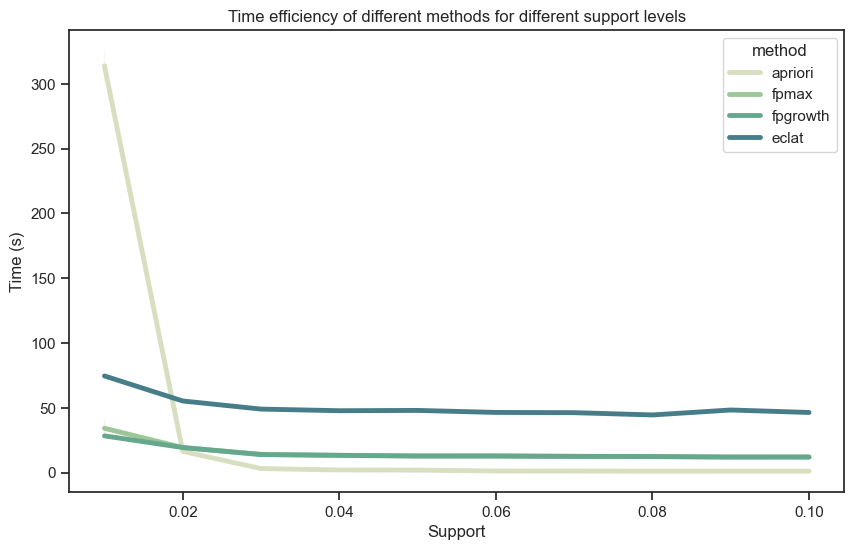

In [87]:
# Plot of how time efficient the different methods are
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 3.5})
plt.figure(figsize=(10, 6))
sns.set_palette(sns.cubehelix_palette(start=.5, rot=-.75)) 
sns.lineplot(x='support', y='time', hue='method', data=results_df)
plt.title('Time efficiency of different methods for different support levels')
plt.xlabel('Support')
plt.ylabel('Time (s)')
plt.savefig('Figures/time_efficiency.png')


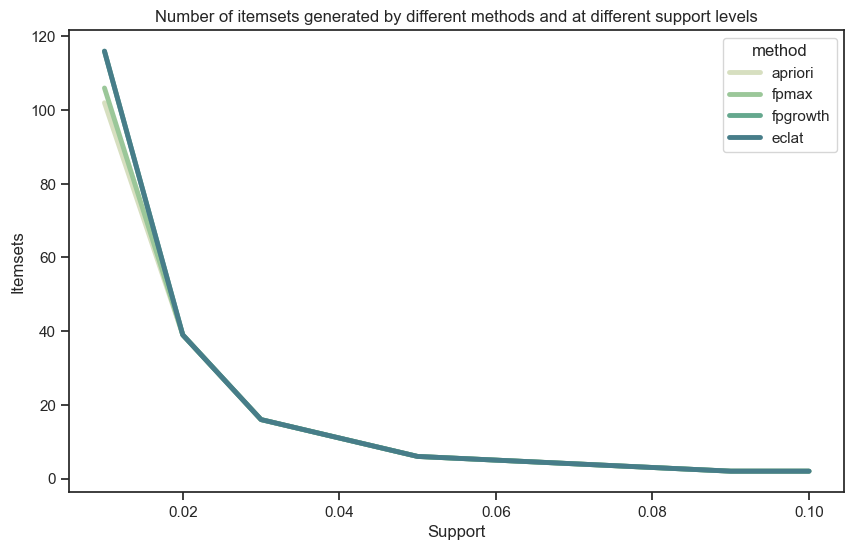

In [88]:
# Plot how many rules are generated by the different methods
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 3.5})
plt.figure(figsize=(10, 6))
sns.set_palette(sns.cubehelix_palette(start=.5, rot=-.75)) 
sns.lineplot(x='support', y='itemsets', hue='method', data=results_df)
plt.title('Number of itemsets generated by different methods and at different support levels')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.savefig('Figures/Itemsets_efficiency.png')
plt.show()


1.3. Summary and analysis of the selected method and support level

Four itemset mining algorithm were tested (Apriori, ECLAT, FP-Growth and FPMax) using the same dataset and a range of support levels ([0.01, 0.05, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]). The dataset used was the 'Order_Products.pickle' dataset which contains 3,214,874 transactions and 49,677 items. 
    
        - In terms of time efficiency, the Apriori algorithm is the slowest of the four specially at lower support levels (0.01). In contrast FPGrowth and FPMax were the fastest algorithms. ECLAT was also fast but slightly slower than FPGrowth and FPMax.

        - In terms if itemset generation at the support level of 0.01, both ECLAT and FPGrowth generated the most itemsets (116), followed by FPmax (106) and Apriori (102).
        
Based on these results, both FPGrowth and ECLAT are good candidates for itemset mining algorithms. However, FPGrowth is the fastest algorithm and generates the most itemsets at the support level of 0.01. Therefore, FPGrowth is the best candidate for itemset mining algorithm.


**2. Identification of the most frequent itemsets and rules**

Objective 2 - Identify the most relevant rules

    From your predefined support level generate all available itemsets and generate rules
    Identify a set of relevant rules and comment them
    Identify the Maximal and Closed Itemsets for the same level of support
    [challenging] Generate the most relevant rules for closed and maximal itemsets with adequate statistics (support, confidence, lift and conviction) and discuss your findings

2.1. Comparing the results of the different metrics and thresholds to identify the most relevant rules.

In [62]:
# Function to generate itemsets and rules using a given method, support level, metric, and min_threshold
def generate_itemsets_and_rules(method, support, metric, min_threshold):
    start_time = time.time()
    if method == 'apriori':
        itemsets = apriori(orders_df, min_support=support, use_colnames=True)
    elif method == 'fpmax':
        itemsets = fpmax(orders_df, min_support=support, use_colnames=True)
    elif method == 'fpgrowth':
        itemsets = fpgrowth(orders_df, min_support=support, use_colnames=True)
    elif method == 'eclat':
        itemsets = pyeclat(order_products_list, support) # eclat requires a list of lists as input
    rules = association_rules(itemsets, metric=metric, min_threshold=min_threshold, support_only=True)
    end_time = time.time()
    return len(itemsets), len(rules), end_time - start_time

In [63]:
# FPGrowth with 0.01 support level and different metrics and min_thresholds
support = 0.01
method = 'fpgrowth'

# Define a list of metrics and min_thresholds to test
metrics = ['lift', 'confidence', 'conviction', 'leverage', 'support']
lift_min_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5] # 0.1 to 5, with a step size of 0.1
confidence_min_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9] # 0.5 and 0.9, with increments of 0.1 
conviction_min_thresholds = [0, 0.1, 0.2, 0.3, 0.4]  #0 and infinity, with increments of 0.1 or 0.01.
leverage_min_thresholds = [-0.1, -0.05, 0, 0.05, 0.1] # -1 and 1, with increments of 0.1 or 0.05.
support_min_thresholds = [0.01, 0.02, 0.03, 0.04, 0.05] # 0 and 1, with increments of 0.01

# Loop over the different metrics and min_thresholds, and generate itemsets and rules for each combination
results = []
for metric in metrics:
    if metric == 'lift':
        thresholds = lift_min_thresholds
    elif metric == 'confidence':
        thresholds = confidence_min_thresholds
    elif metric == 'conviction':
        thresholds = conviction_min_thresholds
    elif metric == 'leverage':
        thresholds = leverage_min_thresholds
    elif metric == 'support':
        thresholds = support_min_thresholds
    else:
        raise ValueError(f"Invalid metric: {metric}")
    
    for min_threshold in thresholds:
        itemsets_count, rules_count, time_elapsed = generate_itemsets_and_rules(method, support, metric, min_threshold)
        results.append((method, metric, support, min_threshold, itemsets_count, rules_count, time_elapsed))

In [64]:
# Dataframe of the results for FPGrowth with 0.01 support level and different metrics and min_thresholds
results_df = pd.DataFrame(results, columns=['method', 'metric', 'support', 'min_threshold', 'itemsets', 'rules', 'time'])
results_df.to_csv('Outputs/FPGrowth_Metrics.csv', index=False)
results_df

,method,metric,support,min_threshold,itemsets,rules,time
0,fpgrowth,lift,0.01,0.10,116,0,33.334305
1,fpgrowth,lift,0.01,0.20,116,0,30.963448
2,fpgrowth,lift,0.01,0.30,116,0,34.326431
3,fpgrowth,lift,0.01,0.40,116,0,30.152440
4,fpgrowth,lift,0.01,0.50,116,0,32.898375
5,fpgrowth,confidence,0.01,0.50,116,0,32.832014
6,fpgrowth,confidence,0.01,0.60,116,0,30.930205
7,fpgrowth,confidence,0.01,0.70,116,0,28.404636
8,fpgrowth,confidence,0.01,0.80,116,0,30.969661
9,fpgrowth,confidence,0.01,0.90,116,0,30.947279


In [71]:
# Dataframe with results that have rules generated
results_df[results_df['rules'] > 0]

,method,metric,support,min_threshold,itemsets,rules,time
10,fpgrowth,conviction,0.01,0.00,116,28,29.631769
15,fpgrowth,leverage,0.01,-0.10,116,28,32.868793
16,fpgrowth,leverage,0.01,-0.05,116,28,32.982367
17,fpgrowth,leverage,0.01,0.00,116,28,30.402734
20,fpgrowth,support,0.01,0.01,116,28,33.980329


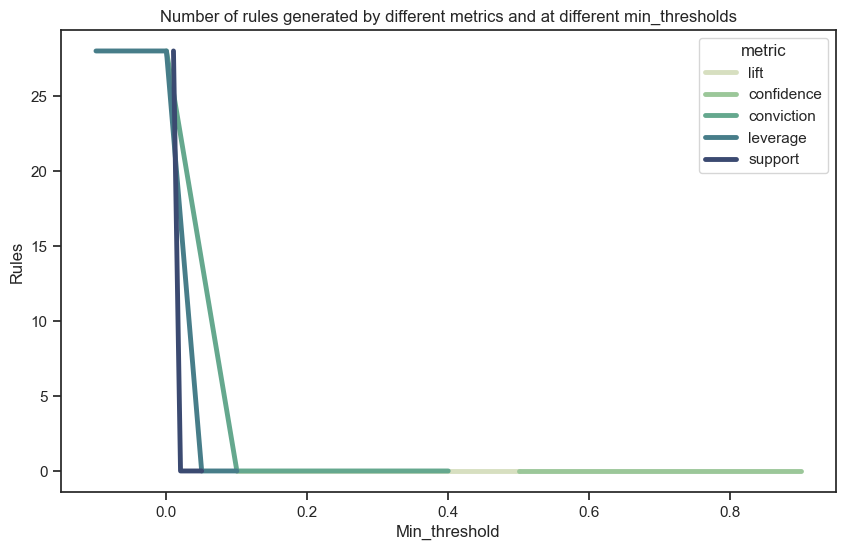

In [67]:
# PLot of how many rules are generated by the different metrics
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 3.5})
plt.figure(figsize=(10, 6))
sns.set_palette(sns.cubehelix_palette(start=.5, rot=-.75))
sns.lineplot(x='min_threshold', y='rules', hue='metric', data=results_df)
plt.title('Number of rules generated by different metrics and at different min_thresholds')
plt.xlabel('Min_threshold')
plt.ylabel('Rules')
plt.savefig('Figures/Metrics.png')
plt.show()

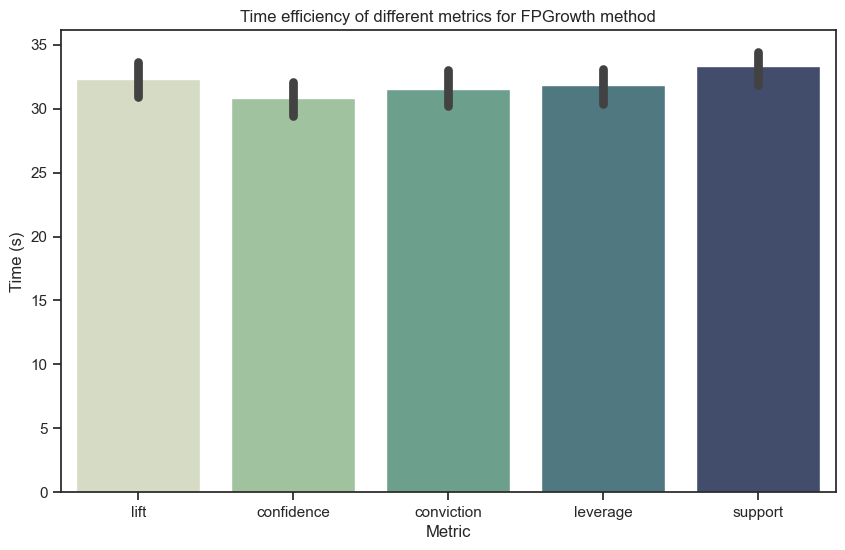

In [68]:
# Visualisation of efficiency of different metrics for FPGrowth method
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 3.5})
plt.figure(figsize=(10, 6))
sns.set_palette(sns.cubehelix_palette(start=.5, rot=-.75))
sns.barplot(x='metric', y='time', data=results_df)
plt.title('Time efficiency of different metrics for FPGrowth method')
plt.xlabel('Metric')
plt.ylabel('Time (s)')
#save image in Figures folder
plt.savefig('Outputs/FPGrowth_Metrics.png')
plt.show()




2.2. Answering questions using the most relevant rules

In [78]:
#Most common items in the dataset
most_common_items = orders_df.sum().sort_values(ascending=False).head(10)
most_common_items

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
dtype: int32

In [76]:
# Most common itemsets  
frequent_itemsets = fpgrowth(orders_df, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False, inplace=True) 
frequent_itemsets

,support,itemsets
10,0.146993,(Banana)
5,0.118030,(Bag of Organic Bananas)
11,0.082331,(Organic Strawberries)
2,0.075251,(Organic Baby Spinach)
6,0.066436,(Organic Hass Avocado)
...,...,...
109,0.010533,"(Organic Strawberries, Organic Raspberries)"
21,0.010230,(Organic Broccoli Florets)
97,0.010199,(Sparkling Lemon Water)
86,0.010120,(Organic Russet Potato)


In [80]:
# Most common rules
rules = association_rules(frequent_itemsets, metric='support', min_threshold=0.01, support_only=True)
rules.sort_values(by='support', ascending=False, inplace=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Hass Avocado),(Bag of Organic Bananas),NaN,NaN,0.019391,NaN,NaN,NaN,NaN,NaN
1,(Bag of Organic Bananas),(Organic Hass Avocado),NaN,NaN,0.019391,NaN,NaN,NaN,NaN,NaN
2,(Organic Strawberries),(Bag of Organic Bananas),NaN,NaN,0.019170,NaN,NaN,NaN,NaN,NaN
3,(Bag of Organic Bananas),(Organic Strawberries),NaN,NaN,0.019170,NaN,NaN,NaN,NaN,NaN
4,(Banana),(Organic Strawberries),NaN,NaN,0.017468,NaN,NaN,NaN,NaN,NaN
5,(Organic Strawberries),(Banana),NaN,NaN,0.017468,NaN,NaN,NaN,NaN,NaN
6,(Organic Avocado),(Banana),NaN,NaN,0.016609,NaN,NaN,NaN,NaN,NaN
7,(Banana),(Organic Avocado),NaN,NaN,0.016609,NaN,NaN,NaN,NaN,NaN
8,(Banana),(Organic Baby Spinach),NaN,NaN,0.015987,NaN,NaN,NaN,NaN,NaN
9,(Organic Baby Spinach),(Banana),NaN,NaN,0.015987,NaN,NaN,NaN,NaN,NaN
